In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

data=np.loadtxt('movielens_100k.csv', delimiter=',',dtype=int) # 读取数据
print('数据集大小:',len(data)) # 打印数据的数量
data[:,:2]=data[:,:2]-1 # 将数据前2列的数字减1，统一索引

users=set()
items=set()
for i,j,k in data:
    users.add(i) # 将用户 ID 和电影 ID 分别添加到对应的集合中。由于集合的特性，重复的元素只会被添加一次。
    items.add(j)
user_num=len(users) # 用户数
item_num=len(items) # 电影数
print(f'用户数:{user_num},电影数：{item_num}')

np.random.seed(0) # 设置随机数种子

ratio=0.8 # 训练集和测试集划分比例依旧是0.8
split=int(len(data)*ratio) # 划分数量
np.random.shuffle(data) # 对数据集进行随机打乱
train=data[:split] # 训练集
test=data[split:] # 测试集

user_cnt=np.bincount(train[:,0],minlength=user_num) # 统计数组中每个非负整数出现的次数，即用户m出现了n次
item_cnt=np.bincount(train[:,1],minlength=item_num)
print(user_cnt[:10]) # 打印前10个评分人评价的电影数量
print(item_cnt[:10])

user_train,user_test=train[:,0],test[:,0]
item_train,item_test=train[:,1],test[:,1]
y_train,y_test=train[:,2],test[:,2]

数据集大小: 100000
用户数:943,电影数：1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


In [8]:
class MF:
    
    def __init__(self,N,M,d):
        self.user_params=np.ones((N,d)) # 这个矩阵表示每个用户的特征向量，每一行对应一个用户的特征向量
        self.item_params=np.ones((M,d))
    
    def pred(self,user_id,item_id):
        user_param=self.user_params[user_id] # 从self.user_params矩阵中提取指定用户的特征向量
        item_param=self.item_params[item_id]
        rating_pred=np.sum(user_param*item_param,axis=1) # 计算用户特征向量和物品特征向量的逐元素乘积，并对结果在axis=1上求和，得到预测的评分
        return rating_pred
    
    def update(self,user_grad,item_grad,lr): # 更新参数的方法
        self.user_params-=lr*user_grad # 根据梯度下降算法，将用户特征矩阵self.user_params减去学习率乘以用户特征矩阵的梯度，从而更新用户特征矩阵
        self.item_params-=lr*item_grad

In [11]:
def train(model,learning_rate,lbd,max_training_step,batch_size):
    '''
    
    :param model: 矩阵分解模型
    :param learning_rate: 学习率，用于控制参数更新的步长
    :param lbd: 正则化系数，用于防止过拟合
    :param max_training_step: 最大训练轮数
    :param batch_size: 每个批次的样本数量
    :return: 
    '''
    train_losses=[] # 分别用于存储每一轮训练后训练集和测试集的均方根误差（RMSE）
    test_losses=[]
    batch_num=int(np.ceil(len(user_train)/batch_size)) # 计算训练集需要划分的批次数量,ceil是计算数组元素向上取整的函数
    with tqdm(range(max_training_step*batch_num))as pbar: # 使用tqdm库创建一个进度条，用于显示训练的进度
        for epoch in range(max_training_step): # 外层循环，控制训练的轮数
            train_rmse=0 # 初始化每一轮训练的均方误差（MSE）累加器。
            for i in range(batch_num): # 内层循环，遍历每个批次
                st=i*batch_size # 计算当前批次的起始和结束索引，确保最后一个批次不会超出训练集的范围。
                ed=min(len(user_train),st+batch_size) # 计算当前批次的起始和结束索引，确保最后一个批次不会超出训练集的范围。
                user_batch=user_train[st:ed] # 从训练集中提取当前批次的用户ID、电影ID和真实评分。
                item_batch=item_train[st:ed] # 从训练集中提取当前批次的用户ID、电影ID和真实评分。
                y_batch=y_train[st:ed] # 从训练集中提取当前批次的用户ID、电影ID和真实评分。
                y_pred=model.pred(user_batch,item_batch) # 调用模型的 pred方法，预测当前批次的用户对电影的评分。
                P=model.user_params # 获取模型的用户特征矩阵
                Q=model.item_params # 获取模型的电影特征矩阵
                errs=y_batch-y_pred # 计算当前批次的预测误差
                P_grad=np.zeros_like(P) # 初始化用户特征矩阵和电影特征矩阵的梯度为零矩阵
                Q_grad=np.zeros_like(Q) # 初始化用户特征矩阵和电影特征矩阵的梯度为零矩阵
                for user, item, err in zip(user_batch,item_batch,errs): # 遍历当前批次的每个样本，计算梯度
                    P_grad[user]=P_grad[user]-err*Q[item]+lbd*P[user]
                    Q_grad[item]=Q_grad[item]-err*P[user]+lbd*Q[item]
                model.update(P_grad/len(user_batch),Q_grad/len(user_batch),learning_rate) # 调用模型的update方法，根据计算得到的梯度和学习率更新用户特征矩阵和电影特征矩阵的参数
                
                train_rmse+=np.mean(errs**2) # 累加当前批次的均方误差
                
                pbar.set_postfix({ # 更新进度条的后缀信息
                    'Epoch':epoch,
                    'Train RMSE':f'{np.sqrt(train_rmse/(i+1)):.4f}',
                    'Test RMSE':f'{test_losses[-1]:.4f}'if test_losses else None
                })
                pbar.update(1) # 显示训练的进度
                
            train_rmse=np.sqrt(train_rmse/len(user_train)) # 计算当前轮训练集的 RMSE
            train_losses.append(train_rmse) # 将当前轮训练集的RMSE添加到train_losses列表中
            y_test_pred=model.pred(user_test,item_test) # 使用训练好的模型对测试集进行预测
            test_rmse=np.sqrt(np.mean((y_test-y_test_pred)**2)) # 计算测试集的 RMSE
            test_losses.append(test_rmse) # 将当前轮测试集的RMSE添加到test_losses列表中
        return train_losses, test_losses

  8%|▊         | 2976/37500 [00:02<00:26, 1293.80it/s, Epoch=2, Train RMSE=1.7490, Test RMSE=1.8760]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 7495/37500 [00:05<00:24, 1238.28it/s, Epoch=5, Train RMSE=1.3578, Test RMSE=1.4528]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 32%|███▏      | 12031/37500 [00:09<00:19, 1308.74it/s, Epoch=9, Train RMSE=1.1901, Test RMSE=1.2464]IOPub message rate exceeded.
The Jupyter server will temporaril

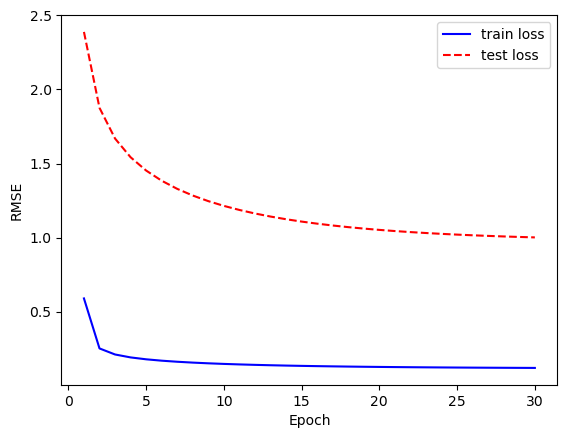

In [12]:
feature_num=16
learning_rate=0.1
lbd=1e-4
max_training_step=30
batch_size=64

model=MF(user_num,item_num,feature_num) # 创建一个MF类的实例
train_losses,test_losses=train(model,learning_rate,lbd,max_training_step,batch_size) # 调用train函数对模型进行训练
plt.figure()
x=np.arange(max_training_step)+1 # x轴
plt.plot(x,train_losses,color='blue',label='train loss')
plt.plot(x,test_losses,color='red',ls='--',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [13]:
y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) 
print(y_test[:10])

[2.57712395 3.48622005 3.76150216 3.58604004 4.8058418  3.47284112
 3.37246031 4.0917956  3.02605747 3.45742155]
[2 4 4 4 5 2 3 1 4 4]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

data = np.loadtxt('fm_dataset.csv', delimiter=',') # 导入数据


np.random.seed(0) # 随机种子
ratio = 0.8 # 划分比例
split = int(ratio * len(data)) # 划分具体边界
x_train = data[:split, :-1] # 划分训练集数据和标签
y_train = data[:split, -1]
x_test = data[split:, :-1] # 划分测试集数据和标签
y_test = data[split:, -1]

feature_num = x_train.shape[1] # 获取特征的数量
print('训练集大小：', len(x_train))
print('测试集大小：', len(x_test))
print('特征数：', feature_num)

训练集大小： 800
测试集大小： 200
特征数： 24


In [15]:
class FM:

    def __init__(self, feature_num, vector_dim):
        self.theta0 = 0.0 # 常数项
        self.theta = np.zeros(feature_num) # 线性参数，用于表示每个特征的线性权重
        self.v = np.random.normal(size=(feature_num, vector_dim)) # 双线性参数，通过np.random.normal函数从正态分布中随机初始化，用于表示特征之间的交互信息。
        self.eps = 1e-6 # 精度参数，防止出现数值不稳定的情况
        
    def _logistic(self, x):
        # 逻辑斯蒂工具函数，用于将预测转化为概率，将输入的实数 x映射到(0,1)区间
        return 1 / (1 + np.exp(-x))

    def pred(self, x):
        # 其中x@self.theta表示输入特征矩阵x与线性参数向量θ的点积，再加上常数项θ0
        linear_term = self.theta0 + x @ self.theta 
        # 先计算输入特征矩阵 x与双线性参数矩阵V的点积，然后对结果进行平方。
        square_of_sum = np.square(x @ self.v)
        sum_of_square = np.square(x) @ np.square(self.v)
        # 最终预测
        y_pred = self._logistic(linear_term \
            + 0.5 * np.sum(square_of_sum - sum_of_square, axis=1))
        # 为了防止后续梯度过大，对预测值进行裁剪，将其限制在某一范围内
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return y_pred
    
    def update(self, grad0, grad_theta, grad_v, lr):
        self.theta0 -= lr * grad0
        self.theta -= lr * grad_theta
        self.v -= lr * grad_v

In [16]:
# 超参数设置，包括学习率、训练轮数等
vector_dim = 16
learning_rate = 0.01
lbd = 0.05
max_training_step = 200
batch_size = 32

# 初始化模型
np.random.seed(0)
model = FM(feature_num, vector_dim)

train_acc = []
test_acc = []
train_auc = []
test_auc = []

with tqdm(range(max_training_step)) as pbar: # 创建一个进度条
    for epoch in pbar: # 外层for循环控制训练轮数，内层while循环将训练集按批次进行处理
        st = 0
        while st < len(x_train):
            ed = min(st + batch_size, len(x_train)) # 确保最后一个批次的样本数量不超过batch_size
            X = x_train[st: ed]
            Y = y_train[st: ed]
            st += batch_size # 起始点索引
            y_pred = model.pred(X) # 调用 FM 模型的 pred 方法，对当前批次的特征数据进行预测
            # 计算交叉熵损失
            cross_entropy = -Y * np.log(y_pred)- (1 - Y) * np.log(1 - y_pred)
            loss = np.sum(cross_entropy) # 将当前批次的交叉熵损失求和
            grad_y = (y_pred - Y).reshape(-1, 1) # 计算损失函数对预测值y的梯度
            grad0 = np.sum(grad_y * (1 / len(X) + lbd)) # 计算损失函数对常数项θ0的梯度，同时加入正则项。
            grad_theta = np.sum(grad_y * (X / len(X)+ lbd * model.theta), axis=0)
            grad_v = np.zeros((feature_num, vector_dim)) # 计算损失函数对线性参数θ的梯度，同样加入正则项。
            for i, x in enumerate(X):
                # 先计算sum(x_i * v_i)
                xv = x @ model.v
                grad_vi = np.zeros((feature_num, vector_dim))
                for s in range(feature_num):
                    grad_vi[s] += x[s] * xv - (x[s] ** 2) * model.v[s]
                grad_v += grad_y[i] * grad_vi
            grad_v = grad_v / len(X) + lbd * model.v
            model.update(grad0, grad_theta, grad_v, learning_rate) # 调用FM模型的update方法，根据计算得到的梯度和学习率更新模型的参数

            pbar.set_postfix({
                '训练轮数': epoch,
                '训练损失': f'{loss:.4f}',
                '训练集准确率': train_acc[-1] if train_acc else None,
                '测试集准确率': test_acc[-1] if test_acc else None
            })
        y_train_pred = (model.pred(x_train) >= 0.5) # 预测准确率，阈值设置为0.5
        acc = np.mean(y_train_pred == y_train)
        train_acc.append(acc)
        auc = metrics.roc_auc_score(y_train, y_train_pred) # sklearn中的AUC函数
        train_auc.append(auc)

        y_test_pred = (model.pred(x_test) >= 0.5)
        acc = np.mean(y_test_pred == y_test)
        test_acc.append(acc)
        auc = metrics.roc_auc_score(y_test, y_test_pred) 
        test_auc.append(auc)
            
print(f'测试集准确率：{test_acc[-1]}，\t测试集AUC：{test_auc[-1]}')

100%|██████████| 200/200 [00:11<00:00, 17.62it/s, 训练轮数=199, 训练损失=11.3006, 训练集准确率=0.816, 测试集准确率=0.785]

测试集准确率：0.79，	测试集AUC：0.7201320910484726


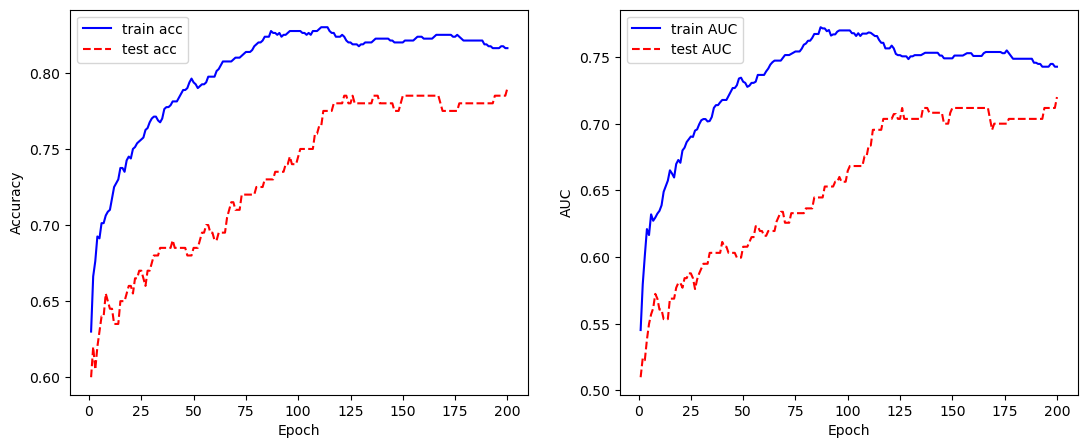

In [17]:
# 绘制训练曲线            
plt.figure(figsize=(13, 5))
x_plot = np.arange(len(train_acc)) + 1

plt.subplot(121)
plt.plot(x_plot, train_acc, color='blue', label='train acc')
plt.plot(x_plot, test_acc, color='red', ls='--', label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(x_plot, train_auc, color='blue', label='train AUC')
plt.plot(x_plot, test_auc, color='red', ls='--', label='test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()